# Correlation and Relationships

In den vorherigen Notebooks haben wir unseren OECD-Wohlstandsdatensatz zunächst **aufbereitet und bereinigt** (Notebook 01) und anschließend **deskriptiv analysiert** (Notebook 02). Dort haben wir insbesondere unsere Zielvariable *"Feeling safe at night"* definiert, ihre Verteilung untersucht und erste Unterschiede zwischen Ländern beobachtet.

In diesem dritten Notebook geht es nun um **Zusammenhänge** zwischen Indikatoren:  
Wir wollen prüfen, ob das wahrgenommene Sicherheitsgefühl mit anderen Wohlstandsindikatoren (z.B. Lebenszufriedenheit, sozialer Unterstützung oder Kriminalität) zusammenhängt – und zwar nicht nur „gefühlt“, sondern mit den Methoden aus den Vorlesungen zur Korrelation.

Aktuell liegen die Werte im Rohdatensatz **untereinander** (eine Zeile pro Measure und Land). Um Korrelationen berechnen zu können, müssen die relevanten Kennzahlen für jedes Land als **Spalten nebeneinander** vorliegen. Im ersten Schritt transformieren wir den Datensatz daher in ein Wide-Format (Pivot), bevor wir visuell und statistisch Zusammenhänge untersuchen.


## 1. Setup & Daten Laden

In [16]:
#!pip install pingouin
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path
import pingouin as pg

In [17]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 8)

In Notebook 01 haben wir zwei zentrale Datensätze, `oecd_snapshot_latest.csv` und `oecd_full_time_series.csv`, eingeführt:

Für eine **Korrelationsanalyse auf Länderebene** ist aus Sicht der Vorlesung die **Unabhängigkeit der Beobachtungen** entscheidend. Deswegen verwenden wir hier bewusst die `snapshot`-Datei (`oecd_snapshot_latest.csv`).

**Warum nicht die Time Series?**

Wenn wir die komplette Zeitreihe nutzen würden, hätten wir für jedes Land mehrere, stark abhängige Beobachtungen (z.B. Österreich 2010, 2011, 2012 …). Das Sicherheitsgefühl eines Landes im Jahr $t$ hängt aber inhaltlich eng mit den Werten in den Folgejahren zusammen. Die Annahme unabhängiger Beobachtungen wäre damit verletzt, und wir würden die Stichprobengröße künstlich „aufblasen“. Das führt typischerweise zu **zu kleinen p-Werten** und damit zu überoptimistischen Ergebnissen.

Da wir in diesem Notebook eine **Querschnittsanalyse über Länder** durchführen wollen (Unsere Frage: *„Haben Länder mit bestimmten Eigenschaften tendenziell ein höheres oder niedrigeres Sicherheitsgefühl?“*), ist es konsequent, nur **eine Beobachtung pro Land** zu verwenden.


In [18]:
base_dir = Path.cwd()
data_file = 'oecd_snapshot_latest.csv'
candidates = [
    base_dir / 'data' / data_file,
    base_dir.parent / 'data' / data_file,
]
data_path = next((p for p in candidates if p.exists()), None)
if data_path is None:
    raise FileNotFoundError(f"Datei nicht gefunden. Versucht wurden: {candidates}")
print(f"Lade Daten von: {data_path}")

try:
    df = pd.read_csv(data_path)
    print("Daten erfolgreich geladen.")

    df = df.loc[:, ~df.columns.duplicated()]
        
except FileNotFoundError:
    print(f"FEHLER: Datei nicht gefunden unter {data_path}")


Lade Daten von: /Users/Flurina/Library/CloudStorage/OneDrive-Persönlich/Documents/Uni_St.Gallen/BCS/3.Semester/Statistik_für_Data_Science/Projekt/Statistik_Projekt_OECDWellBeing/data/oecd_snapshot_latest.csv
Daten erfolgreich geladen.


## 2. Daten Transformation

Im Rohformat steht jede Zeile für eine Kombination aus Land (*reference_area*), Indikator (*measure*) und Wert (*value*). Für eine Korrelationsanalyse benötigen wir jedoch eine Struktur, in der **jede Zeile ein Land** ist und **jede Spalte ein Indikator**.

Dafür verwenden wir einen `pivot`:

- Index: `reference_area` (Länder)
- Spalten: `measure` (Indikatoren)
- Werte: `value` (Kennzahlen, hier gemittelt, falls mehrere Werte vorkommen)

Nach dem Pivot sehen wir, dass wir einen Datensatz mit `n = 47` Ländern erhalten. Damit haben wir eine saubere Basis, um Korrelationen zwischen den einzelnen Indikatoren zu berechnen.

In [19]:
target_sex = 'Total' if 'Total' in df['sex'].unique() else '_T'
target_age = 'Total' if 'Total' in df['age'].unique() else '_T'

In [20]:
mask = (df['sex'] == target_sex) & (df['age'] == target_age)
df_filtered = df[mask].copy()

In [21]:
df_pivot = df_filtered.pivot_table(
    index='reference_area', 
    columns='measure', 
    values='value',
    aggfunc='mean' 
)

print(f"\nDatensatz transformiert. Anzahl Länder: {len(df_pivot)}")


Datensatz transformiert. Anzahl Länder: 47


### 3. VARIABLEN SELEKTION

Wir behalten unsere **Zielvariable** `Feeling safe at night`

Aus dem `pivot`-Datensatz stehen uns viele weitere Wohlstandsindikatoren zur Verfügung (Einkommen, Gesundheit, Umwelt, subjektives Wohlbefinden, etc.). Wir wählen für dieses Notebook gezielt diejenigen Variablen aus, die inhaltlich plausibel mit dem Sicherheitsgefühl zusammenhängen könnten und in den Vorlesungen auch als Beispiele für Korrelation und Regressionsanalysen dienen könnten:

- **Sozialer Kontext / Unterstützung**: z.B. `Social support` / `Lack of social support`, `Satisfaction with personal relationships`
- **Subjektives Wohlbefinden**: `Life satisfaction`, `Negative affect balance`
- **Kriminalität / Risiko**: `Homicides`, `Road deaths`
- **Ökonomischer Hintergrund**: `Median net wealth`, `Households and NPISHs net adjusted disposable income per capita`, `Difficulty making ends meet`

Wir beschränken uns bewusst auf eine **überschaubare Auswahl** an Variablen, statt „blind“ alle Spalten zu korrelieren. So bleiben die Analysen interpretierbar, und jede Korrelation lässt sich inhaltlich begründen. Gleichzeitig behalten wir mit der späteren Korrelationsmatrix einen Überblick, ob vielleicht unerwartete Zusammenhänge auftauchen.


In [22]:
# Zielvariable aus Notebook 2
target_var = "Feeling safe at night"

# Verfügbare Indikatoren prüfen
print(df_pivot.columns.tolist())

['Access to green space', 'Adult literacy skills', 'Adult numeracy skills', 'Adults with low literacy skills', 'Adults with low numeracy skills', 'Average annual gross earnings', 'Deaths from suicide, alcohol, drugs', 'Difficulty making ends meet', 'Employment rate', 'Equivalised liquid financial assets below three months of the annual national relative income poverty line', 'Exposed to air pollution', 'Exposure to extreme temperature', 'Feeling lonely', 'Feeling safe at night', 'Feelings of physical pain', 'Full-time employees earning less than two-thirds of gross median earnings', 'Gender gap in working hours', 'Gender wage gap', 'Having a say in government', 'Homicides', 'Household disposable income below the relative income poverty line', 'Households and NPISHs net adjusted disposable income per capita', 'Households living in overcrowded conditions', 'Households with internet access at home', 'Housing affordability', 'Housing cost overburden', 'Inability to keep home adequately war

In [23]:
potential_drivers = [
    "Social support",    
    "Homicides",         
    "Life satisfaction", 
    "Median net wealth",
    "Difficulty making ends meet"
]

In [24]:
# intersection, um Tippfehler abzufangen
cols_to_use = [target_var] + potential_drivers
# nur die Spalten nehmen, die auch wirklich da sind
valid_cols = df_pivot.columns.intersection(cols_to_use)
df_corr = df_pivot[valid_cols].copy()

# alle Daten -> Zahlenformat, alles was kein Text ist -> NaN
for col in df_corr.columns:
    df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')

# Wir löschen Länder, die in diesen Spalten NaNs haben (Listwise Deletion) -> Korrelation braucht vollständige Paare
df_corr = df_corr.dropna()

print(f"\nAnalyse-Tabelle erstellt mit {df_corr.shape[0]} Ländern.")
df_corr.head()


Analyse-Tabelle erstellt mit 26 Ländern.


measure,Difficulty making ends meet,Feeling safe at night,Homicides,Life satisfaction,Median net wealth,Social support
reference_area,,,,,,
Austria,13.1,82.546060,0.4,7.575,189148.0,89.024267
Belgium,17.2,68.829203,0.7,7.550,343656.0,91.298786
Canada,20.4,73.163202,0.8,7.400,336829.0,90.730572
Croatia,19.8,77.833333,0.7,7.125,151212.0,90.838590
Czechia,14.2,76.741255,0.5,7.425,193239.0,93.843487


## 4. Visuelle Prüfung

Bevor wir Korrelationen als reine Zahlen berechnen, schauen wir zunächst **grafisch** auf die Zusammenhänge. Dafür erstellen wir Scatterplots mit Regressionslinie.

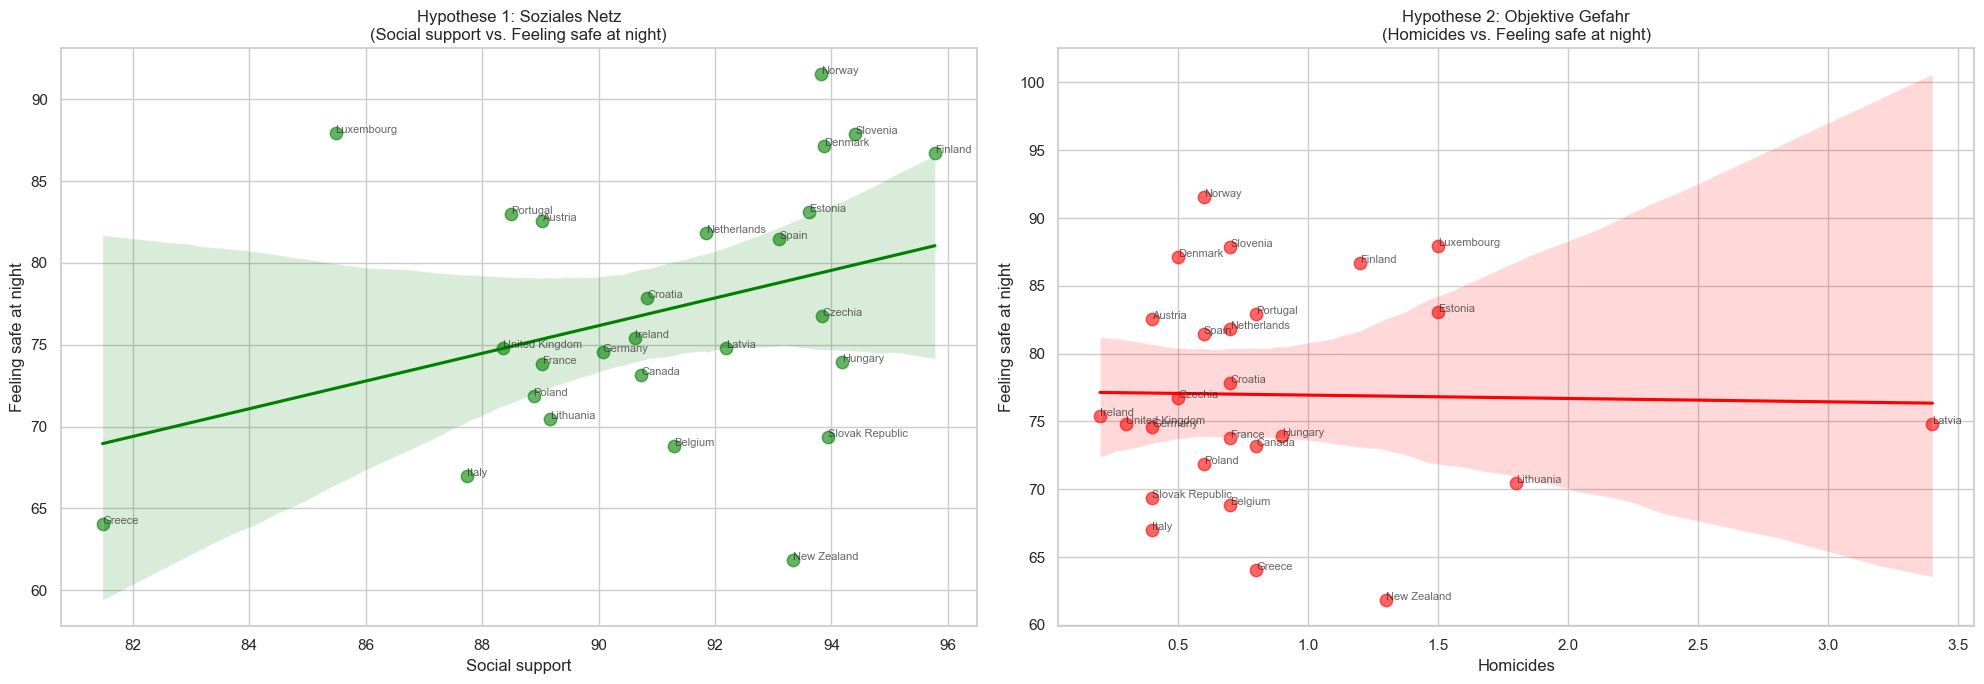

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plot 1: Social Support
sns.regplot(data=df_corr, x="Social support", y=target_var, ax=ax[0], 
            color="green", scatter_kws={'s': 80, 'alpha': 0.6})
ax[0].set_title(f"Hypothese 1: Soziales Netz\n(Social support vs. {target_var})")

# Plot 2: Homicides
sns.regplot(data=df_corr, x="Homicides", y=target_var, ax=ax[1], 
            color="red", scatter_kws={'s': 80, 'alpha': 0.6})
ax[1].set_title(f"Hypothese 2: Objektive Gefahr\n(Homicides vs. {target_var})")

for i in range(df_corr.shape[0]):
    ax[0].text(df_corr["Social support"].iloc[i], df_corr[target_var].iloc[i], 
               df_corr.index[i], fontsize=8, alpha=0.7)
    ax[1].text(df_corr["Homicides"].iloc[i], df_corr[target_var].iloc[i], 
               df_corr.index[i], fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

### Visuelle Inspektion (Scatterplot)

**Beobachtung:**
Der Scatterplot zeigt den Zusammenhang zwischen *"Life Satisfaction"* (x-Achse) und *"Feeling safe at night"* (y-Achse).
* Wir sehen eine tendenziell **positive Steigung**: Länder mit höherer Lebenszufriedenheit weisen oft auch ein höheres Sicherheitsgefühl auf.
* Die Punktwolke ist jedoch nicht perfekt linear, sondern eher diffus ("bauchig").
* Einzelne Länder weichen stark vom Trend ab. Eine rein lineare Regression (rote Linie) würde versuchen, diese Punkte zu "fangen" und könnte dadurch verzerrt werden.

=> Die visuelle Diagnose bestätigt unsere Entscheidung gegen Pearson. Ein Rang-basiertes Maß ist notwendig, um den "allgemeinen Trend" (Monotonie) zu quantifizieren, ohne von der Streuung der Ausreißer dominiert zu werden.

Im Scatterplot zwischen *Life satisfaction* und *Feeling safe at night* sehen wir:

- Die Punktewolke zeigt eine **tendenziell steigende Tendenz**: Länder mit hoher Lebenszufriedenheit berichten häufig auch ein höheres Sicherheitsgefühl.
- Der Zusammenhang ist aber **nicht perfekt linear**. Die Punktwolke wirkt eher „bauchig“ und weist eine gewisse Streuung auf.
- Einige Länder liegen deutlich abseits des groben Trends (potentielle Ausreißer).

Die eingezeichnete Regressionslinie fasst den Trend zwar zusammen, aber die Streuung der Punkte macht deutlich, dass eine rein lineare Annahme zu kurz greift.  

Diese visuelle Diagnose ist wichtig, weil sie später unsere Wahl des Korrelationsmaßes stützt: wir wollen ein Maß, das **monotone, nicht notwendigerweise lineare** Beziehungen erfassen kann und **robust gegenüber Ausreißern** ist.

## Analyse der beiden Plots: Soziales Netz vs. Sicherheitsgefühl & Mordrate vs. Sicherheitsgefühl

Im linken Plot („Social Support vs. Perceived Safety“) zeigt sich eine klare positive Korrelation: Länder mit höherem Social Support weisen tendenziell ein höheres nächtliches Sicherheitsgefühl auf. Die Regressionslinie steigt deutlich an, und die geringe Streuung im oberen Bereich (Social Support > 90) zeigt, dass Social Support ein relativ starker Prädiktor für das subjektive Sicherheitsgefühl ist.
Auffällig sind Slowenien und Norwegen als Spitzenreiter. Südafrika hingegen bildet einen deutlichen Ausreißer: Trotz moderatem Social Support ist das Sicherheitsgefühl extrem niedrig – vermutlich wegen der realen Kriminalitätslage (siehe Plot 2).

Der rechte Plot („Homicide Rate vs. Perceived Safety“) zeigt dagegen fast keinen linearen Zusammenhang. Die Regressionslinie verläuft nahezu horizontal. Besonders im großen Cluster der Länder mit niedriger Mordrate (0–2) variiert das subjektive Sicherheitsgefühl stark (ca. 50–90 %), sodass die Homicide Rate hier kein guter erklärender Faktor ist.
Bei den Ländern mit extrem hohen Mordraten – Mexiko, Kolumbien, Brasilien, Südafrika – wird der Zusammenhang deutlicher. Interessant ist jedoch das Paradoxon Mexiko: Trotz höchster Homicide Rate ist das Sicherheitsgefühl nicht am niedrigsten. Südafrika zeigt den erwarteten negativen Zusammenhang am stärksten.

Social Support ist ein deutlich verlässlicherer Indikator für das subjektive Sicherheitsgefühl als die Homicide Rate. Während die Mordrate nur extreme Unsicherheit erklärt, differenziert Social Support klar zwischen den sonst ähnlich „objektiv sicheren“ Ländern.

## 5. Korrelation

In der deskriptiven Analyse haben wir festgestellt, dass unsere Zielvariable *"Feeling safe at night"* **nicht normalverteilt** ist (siehe QQ-Plot) und eine **Linksschiefe** sowie **Ausreißer** aufweist (siehe Histogramm & Boxplot).

Aufgrund dieser Verletzung der Annahmen ist der klassische **Pearson-Korrelationskoeffizient** ($r$) hier methodisch inkorrekt, da er Normalverteilung und Linearität voraussetzt und anfällig für Ausreißer ist. -> Wir nutzen nichtpararametrische Verfahren (**Rangkorrelationen**)

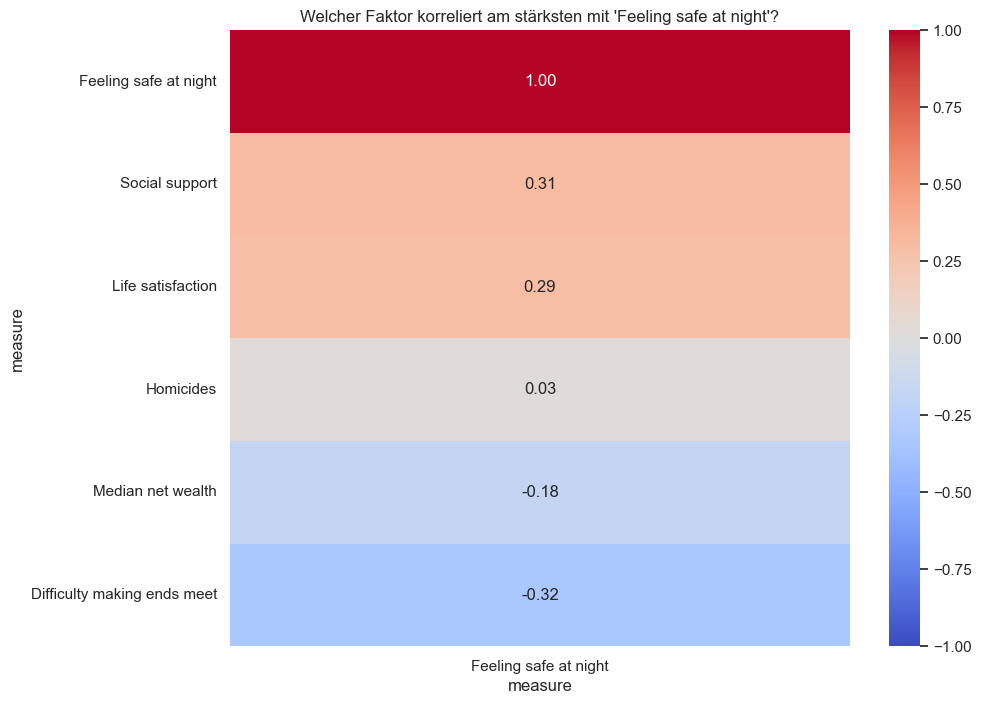

In [26]:
corr_matrix = df_corr.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[[target_var]].sort_values(by=target_var, ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title(f"Welcher Faktor korreliert am stärksten mit '{target_var}'?")
plt.show()

In der Heatmap sehen wir:

- Mehrere Indikatoren, die **positiv** mit dem Sicherheitsgefühl korrelieren, z.B. Variablen im Bereich subjektives Wohlbefinden und soziale Unterstützung (etwa *Life satisfaction*, *Social support* oder *Satisfaction with personal relationships*).
- Andere Variablen weisen eher **negative** Zusammenhänge auf, etwa solche, die Belastungen oder Risiken messen (z.B. *Feeling lonely*, *Homicides* oder Indikatoren finanzieller Unsicherheit).

Die Korrelationen sind überwiegend im **kleinen bis mittleren Bereich**, was typisch ist für aggregierte Länderdaten: viele Faktoren wirken gleichzeitig, und einzelne Indikatoren erklären nur einen Teil der Variation im Sicherheitsgefühl.

Die Heatmap dient uns hier vor allem als **Orientierung**, um zu entscheiden:

- Welche Variablen sind gute Kandidaten für einen **formalen Hypothesentest** (NB 03)?  
- Welche Variablen bieten sich später als **Prädiktoren in Regressionsmodellen** an (NB 05)?


Wir verwenden zwei unterschiedliche Rangkorrelationsmaße:

1. **Spearman's Rho ($\rho$)**  
   Spearman misst, ob ein Zusammenhang **monoton** ist, d.h. ob Länder mit höherem Wert in Variable A tendenziell einen höheren (oder niedrigeren) Wert in Variable B haben, unabhängig vom exakten funktionalen Verlauf. Dazu werden die Werte in Ränge umgewandelt. Ausreißer wie einzelne Länder mit extrem hoher oder niedriger Mordrate beeinflussen dann nur ihren Rang, nicht mehr den absoluten Abstand.

2. **Kendall's Tau ($\tau$)**  
   Kendall basiert auf der Zahl **konkordanter** vs. **diskordanter** Paare. Intuitiv betrachtet prüft Kendall, wie oft zwei Länder in beiden Variablen in der gleichen Reihenfolge sortiert sind.  
   Dieses Maß ist besonders hilfreich, wenn die Stichprobe – wie hier mit ca. zwei Dutzend Ländern – eher klein ist und es viele ähnliche Werte gibt (Ties).

Wenn beide Maße in die gleiche Richtung zeigen und ähnliche Signifikanzniveaus liefern, ist das ein starkes Indiz dafür, dass der gefundene Zusammenhang **robust** ist und nicht von der Wahl des konkreten Rangkorrelationsmaßes abhängt.

In [27]:
corr_spearman, p_spearman = stats.spearmanr(df_corr["Social support"], df_corr["Homicides"])
corr_kendall, p_kendall = stats.kendalltau(df_corr["Social support"], df_corr["Homicides"])

print(f"--- Vergleich der Rangkorrelationen für '{v1}' vs. '{v2}' ---")
print(f"Spearman rho: {corr_spearman:.4f} (p={p_spearman:.4f})")
print(f"Kendall tau:  {corr_kendall:.4f} (p={p_kendall:.4f})")

--- Vergleich der Rangkorrelationen für 'Social support' vs. 'Homicides' ---
Spearman rho: 0.1081 (p=0.5992)
Kendall tau:  0.0544 (p=0.7055)


## 6. Hypothesentest

Auf Basis der Korrelationsmatrix wählen wir zwei inhaltlich zentrale Kandidaten für einen formalen Test aus:

- *Social support* – als positive, soziale Ressource.
- *Homicides* – als direkte Kriminalitätskennzahl.

Wir formulieren für jede Variable einen **zweiseitigen Hypothesentest** auf Basis der Spearman-Korrelation:

- $H_0$: Es gibt **keinen monotonen Zusammenhang** zwischen der Variable und *Feeling safe at night* ($\rho = 0$).
- $H_1$: Es gibt einen **monotonen Zusammenhang** ($\rho \neq 0$).

Der Code kapselt diesen Ablauf (Hypothesen, Teststatistik, p-Wert, Entscheidung bei $\alpha = 0{,}05$) in einer Funktion, sodass wir die Logik transparent dokumentieren und wiederverwenden können.

In [28]:
def test_correlation(var_name):
    """Führt einen Spearman-Test gegen die Zielvariable durch und gibt das Ergebnis aus."""
    
    # 1. Hypothesen aufstellen
    print(f"\n--- Test: {target_var} vs. {var_name} ---")
    print("H0: Es gibt keinen monotonen Zusammenhang (rho = 0).")
    print("H1: Es gibt einen monotonen Zusammenhang (rho != 0).")
    
    # 2. Test durchführen
    corr, p_val = stats.spearmanr(df_corr[target_var], df_corr[var_name])
    
    # 3. Ergebnisse
    print(f"Spearman-Korrelation (rho): {corr:.4f}")
    print(f"p-Wert: {p_val:.6f}")
    
    # 4. Entscheidung
    alpha = 0.05
    if p_val < alpha:
        print("ENTCHEIDUNG: p < 0.05 -> H0 verwerfen. Der Zusammenhang ist signifikant.")
    else:
        print("ENTCHEIDUNG: p >= 0.05 -> H0 beibehalten. Kein signifikanter Zusammenhang nachweisbar.")

# Wir testen unsere beiden Haupt-Kandidaten
test_correlation("Social support")
test_correlation("Homicides")


--- Test: Feeling safe at night vs. Social support ---
H0: Es gibt keinen monotonen Zusammenhang (rho = 0).
H1: Es gibt einen monotonen Zusammenhang (rho != 0).
Spearman-Korrelation (rho): 0.3060
p-Wert: 0.128458
ENTCHEIDUNG: p >= 0.05 -> H0 beibehalten. Kein signifikanter Zusammenhang nachweisbar.

--- Test: Feeling safe at night vs. Homicides ---
H0: Es gibt keinen monotonen Zusammenhang (rho = 0).
H1: Es gibt einen monotonen Zusammenhang (rho != 0).
Spearman-Korrelation (rho): 0.0293
p-Wert: 0.887165
ENTCHEIDUNG: p >= 0.05 -> H0 beibehalten. Kein signifikanter Zusammenhang nachweisbar.


Die Ergebnisse für unseren Datensatz lauten:

- **Feeling safe at night vs. Social support**  
  $\rho \approx 0{,}31$, p-Wert $\approx 0{,}13$.  
  Der Zusammenhang ist also **positiv**, aber bei $\alpha = 0{,}05$ **nicht signifikant**. Wir behalten \(H_0\) bei.

- **Feeling safe at night vs. Homicides**  
  $\rho \approx 0{,}03$, p-Wert $\approx 0{,}89$.  
  Hier ist praktisch **kein monotones Muster** erkennbar, und der p-Wert ist deutlich größer als 0{,}05.

!! Das bedeutet nicht, dass es „keinen Zusammenhang“ im Alltag gibt, sondern nur, dass wir mit dieser Stichprobe von OECD-Ländern und dieser Operationalisierung **keinen statistisch signifikanten monotonen Zusammenhang** nachweisen können. In Notebook 04 werden wir ähnliche Fragen mit **Gruppenvergleichen** prüfen, und in Notebook 05 betrachten wir dieselben Variablen noch einmal im Rahmen von **Regressionsmodellen**, die mehrere Faktoren gleichzeitig berücksichtigen.

## 7. DRITTVARIABLEN-CHECK


Drittvariable kontrollieren: Median Wealth Split bei 186496.0


<Figure size 1000x600 with 0 Axes>

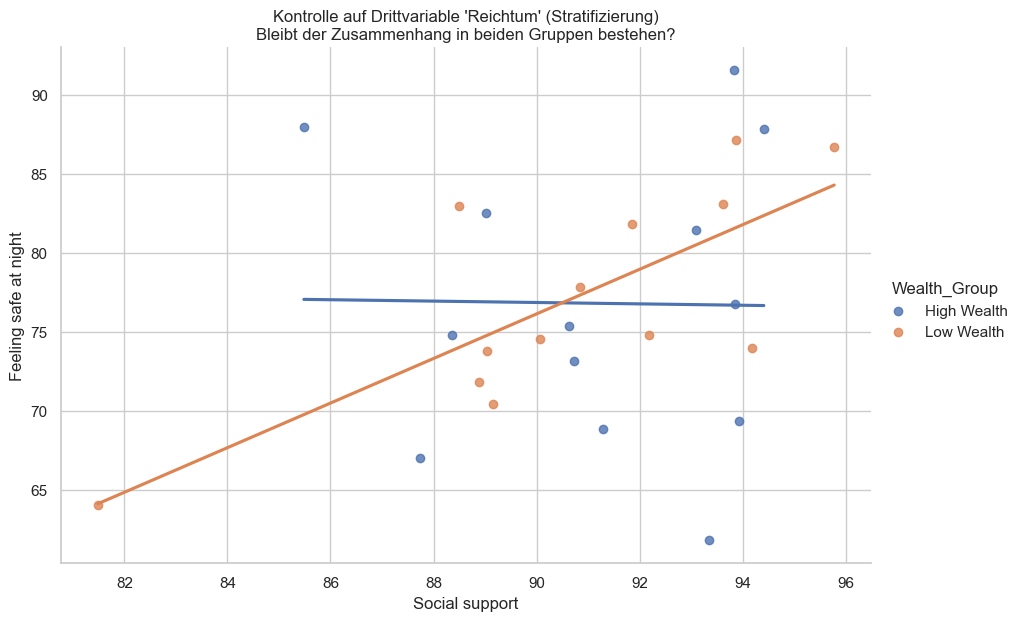

In [29]:
wealth_median = df_corr["Median net wealth"].median()
df_corr["Wealth_Group"] = np.where(df_corr["Median net wealth"] > wealth_median, "High Wealth", "Low Wealth")

print(f"\nDrittvariable kontrollieren: Median Wealth Split bei {wealth_median}")

plt.figure(figsize=(10, 6))
sns.lmplot(data=df_corr, x="Social support", y=target_var, hue="Wealth_Group", 
           height=6, aspect=1.5, ci=None)

plt.title("Kontrolle auf Drittvariable 'Reichtum' (Stratifizierung)\nBleibt der Zusammenhang in beiden Gruppen bestehen?")
plt.show()

### Korrelation $\neq$ Kausalität

Wir haben statistisch signifikante Zusammenhänge gefunden. 

1.  **Drittvariablen-Problem (Confounding):**
    * Es ist möglich, dass sowohl das Sicherheitsgefühl als auch z.B. die Lebenszufriedenheit durch eine dritte, nicht gemessene Variable beeinflusst werden (z.B. *Politische Stabilität* oder *Qualität des Gesundheitssystems*).
    * Beispiel: Reiche Länder haben oft beides – hohe Sicherheit und hohe Zufriedenheit. Der Zusammenhang könnte also rein ökonomisch getrieben sein.

2.  **Simpson-Paradox:**
    * Da wir Daten auf Länderebene aggregiert haben ("Ecological Fallacy"), gilt der gefundene Zusammenhang nicht zwingend für Individuen. Es könnte sein, dass in *einem* Land reichere Menschen *nicht* sicherer sind, obwohl der Trend im Ländervergleich so aussieht.

**Fazit:** Die Korrelationen sind starke Hinweise auf strukturelle Zusammenhänge, aber kein Beweis für einen direkten ursächlichen Mechanismus.

## 8. PARTIELLE KORRELATION

In [30]:
try:
    pcorr_df = df_corr.pcorr()

    stats_pcorr = pg.partial_corr(data=df_corr, x='Social support', y=target_var, 
                                 covar='Median net wealth', method='spearman')
    
    print("\n--- Partielle Korrelation (Kontrolle auf Reichtum) ---")
    print(stats_pcorr)
    
except ImportError:
    print("Pingouin nicht installiert. Führe '!pip install pingouin' aus für detaillierte Partial-Corr.")
    corrs = df_corr.groupby("Wealth_Group")[["Social support", target_var]].corr(method="spearman").iloc[0::2, -1]
    print("\n--- Korrelation in den Subgruppen (Stratifizierung) ---")
    print(corrs)


--- Partielle Korrelation (Kontrolle auf Reichtum) ---
           n         r         CI95%     p-val
spearman  26  0.271128  [-0.14, 0.6]  0.189873
